In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime

# ----------------------------
# 1. Data Loading and Preprocessing
# ----------------------------
df = pd.read_csv('weekly_df_with_tickers.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['risk_premium'])
df.sort_values(['Ticker', 'Date'], inplace=True)

# Compute the lagged risk premium for each ticker individually.
df['risk_premium_lag'] = df.groupby('Ticker')['risk_premium'].shift(1)

# Create lagged risk premium for Random Walk prediction

df.dropna(subset=['risk_premium_lag'], inplace=True)

# ----------------------------
# 2. Define the Rolling Window Forecast Function (Random Walk)
# ----------------------------
def rolling_window_forecast_rw(df, initial_train_start, initial_train_end,
                               validation_window_years=1, rolling_step=1):
    """
    Performs rolling window forecasting using a Random Walk model and returns both a summary of each window
    and detailed results with year, actual, and predicted values.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset (must have a DateTimeIndex, and columns 'risk_premium' and 'risk_premium_lag')
    initial_train_start : str or datetime
        Start date of the initial training period
    initial_train_end : str or datetime
        End date of the initial training period
    validation_window_years : int, default 1
        The length of the validation period (in years)
    rolling_step : int, default 1
        The number of years to shift the window for each iteration

    Returns:
    --------
    summary_results : list of dicts
        A summary of each rolling window including train/validation dates and R² score
    detailed_results_df : pandas.DataFrame
        Detailed results DataFrame with columns: year, actual, and predicted values for the validation period
    """
    summary_results = []
    detailed_results = []  # Used to store detailed validation results for each window

    # Convert dates to Timestamp objects
    train_start = pd.to_datetime(initial_train_start)
    train_end = pd.to_datetime(initial_train_end)
    val_start = train_end + pd.DateOffset(days=1)
    val_end = val_start + pd.DateOffset(years=validation_window_years) - pd.DateOffset(days=1)

    max_date = df.index.max()

    # Random Walk prediction: use the previous period's risk premium as the prediction
    feature_col = 'risk_premium_lag'

    while train_start < max_date:
        # Adjust the validation end date if it exceeds the available data range
        if val_end > max_date:
            val_end = max_date

        # Get the current window's training and validation data
        train_data = df.loc[(df.index >= train_start) & (df.index <= train_end)]
        val_data = df.loc[(df.index >= val_start) & (df.index <= val_end)]
        if train_data.empty or val_data.empty:
            break

        # For Random Walk, the validation prediction is simply the lagged risk premium
        y_val = val_data['risk_premium']
        # Use the lagged risk premium (which represents t-1) as the prediction
        y_pred = val_data[feature_col]

        # Compute R² score
        overall_r2 = r2_score(y_val, y_pred)

        # Record summary information (model parameters are not applicable here)
        summary_results.append({
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end,
            'overall_r2': overall_r2,
            'model': 'Random Walk'
        })

        print(f"Train: {train_start.date()} to {train_end.date()} | "
              f"Validation: {val_start.date()} to {val_end.date()} | "
              f"Overall R²: {overall_r2:.4f} | Model: Random Walk")

        # Save detailed validation results: each date's year, actual value, and predicted value
        df_detail = pd.DataFrame({
            'year': val_data.index.year,
            'actual': y_val.values,
            'predicted': y_pred.values
        }, index=val_data.index)
        detailed_results.append(df_detail)

        # Update the window (shift each boundary forward by rolling_step years)
        train_start += pd.DateOffset(years=rolling_step)
        train_end += pd.DateOffset(years=rolling_step)
        val_start += pd.DateOffset(years=rolling_step)
        val_end += pd.DateOffset(years=rolling_step)

    # Concatenate all detailed validation results
    if detailed_results:
        detailed_results_df = pd.concat(detailed_results)
    else:
        detailed_results_df = pd.DataFrame()

    return summary_results, detailed_results_df

# ----------------------------
# 3. Run the Rolling Window Forecast for Random Walk
# ----------------------------
summary_results_rw, detailed_results_df_rw = rolling_window_forecast_rw(
    df,
    initial_train_start='1990-01-01',
    initial_train_end='2015-12-31',
    validation_window_years=1,   # validation period of 1 year
    rolling_step=1
)

# Convert summary results to a DataFrame
results_df_rw = pd.DataFrame([{
    'train_start': r['train_start'],
    'train_end': r['train_end'],
    'val_start': r['val_start'],
    'val_end': r['val_end'],
    'overall_r2': r['overall_r2'],
    'model': r['model']
} for r in summary_results_rw])

print("\nSummary Results (Rolling Window Random Walk):")
print(results_df_rw)

print("\nDetailed Results (Year, Actual, Predicted):")
print(detailed_results_df_rw.head())

# Save the results to CSV files
results_df_rw.to_csv("rolling_window_results_rw_summary.csv", index=False)
detailed_results_df_rw = detailed_results_df_rw.reset_index(drop=True)
detailed_results_df_rw.to_csv("rolling_window_results_rw_detailed.csv", index=False)

,risk_premium,Ticker,mom1m,mom12m,mom36m,chmom,maxret,mvel1,dolvol,ill,...,rect_turn,pay_turn,sale_invcap,sale_equity,sale_nwc,ptb,TBL,TMS,DFY,risk_premium_lag
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-12,-0.000296,AAPL,-0.041667,-0.194478,0.448650,-0.152811,0.056737,17.546802,4.173297e+07,3.638351e-10,...,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.50,0.60,0.95,0.003025
1990-01-19,0.057609,AAPL,-0.021427,-0.156428,0.395225,-0.135001,0.057915,17.972879,6.390314e+07,4.438585e-10,...,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.74,0.52,0.95,-0.000296
1990-01-26,-0.040597,AAPL,-0.067614,-0.121020,0.207917,-0.053406,0.057915,17.547722,4.177137e+07,4.824237e-10,...,7.382,7.965000,3.556000,3.556000,3.776,2.387,7.68,0.81,0.95,0.057609
1990-02-02,0.018281,AAPL,-0.089701,-0.118817,0.298334,-0.029116,0.057915,17.167320,2.855436e+07,4.909231e-10,...,7.382,7.965000,3.556000,3.556000,3.776,2.303,7.81,0.69,0.92,-0.040597
1990-02-09,0.037574,AAPL,-0.007246,-0.071505,0.128529,-0.064259,0.057915,17.517061,4.051005e+07,5.158342e-10,...,7.382,7.965000,3.556000,3.556000,3.776,2.303,7.76,0.55,0.92,0.018281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,0.017682,ZBRA,0.218344,-0.107518,-0.362560,-0.325862,0.064409,18.432767,1.012159e+08,1.847212e-10,...,7.213,4.428333,1.084333,1.883667,358.917,3.941,5.23,-1.01,0.90,0.013334
2023-12-08,0.012224,ZBRA,0.143819,-0.064980,-0.368349,-0.208799,0.064409,17.809782,5.428629e+07,1.622876e-10,...,7.213,4.449752,1.020657,1.764997,358.917,3.941,5.24,-1.01,0.90,0.017682
2023-12-15,-0.007485,ZBRA,0.245299,0.033193,-0.295415,-0.212106,0.113448,19.439292,2.769345e+08,1.483629e-10,...,7.213,4.452572,1.012272,1.749370,358.917,3.941,5.24,-1.33,0.90,0.012224


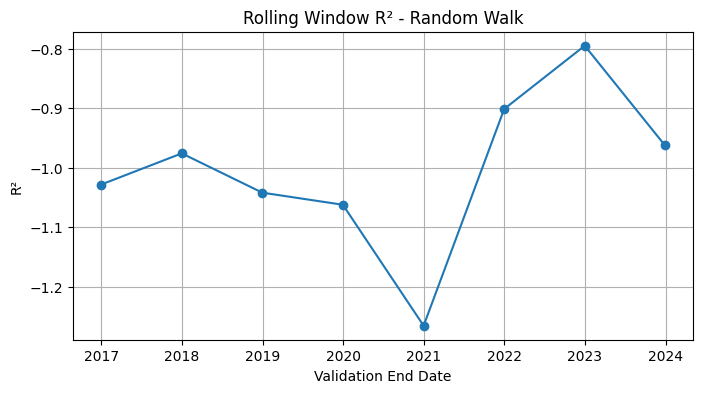

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(results_df_rw['val_end'], results_df_rw['overall_r2'], marker='o', linestyle='-')
plt.title("Rolling Window R² - Random Walk")
plt.xlabel("Validation End Date")
plt.ylabel("R²")
plt.grid(True)
plt.show()